# Train data iterator

In [1]:
# https://ipython.org/ipython-doc/3/config/extensions/autoreload.html
%load_ext autoreload
%autoreload 2

In [2]:
import os
import logging
import sys
sys.path.append("../common/")

import cv2
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline

/usr/local/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [3]:
from data_utils import TRAIN_IMAGE_IDS, LABELS, TRAIN_DATA, TRAIN_WKT
from image_utils import get_image_data, get_image_tile_data, normalize
from visu_utils import display_img_1b, display_labels, plt_st

In [4]:
from glob import glob
all_train_ids = glob(os.path.join(TRAIN_DATA, "*.tif"))
all_train_ids = np.array([s[len(TRAIN_DATA)+1:-4] for s in all_train_ids if 'mean' not in s and 'std' not in s])
print "First & last train ids : ", all_train_ids[0], all_train_ids[-1], len(all_train_ids)

First & last train ids :  6010_1_2 6170_4_1 25


In [5]:
LABELS

['None',
 'Buildings',
 'Misc. Manmade structures',
 'Road',
 'Track',
 'Trees',
 'Crops',
 'Waterway',
 'Standing water',
 'Vehicle Large',
 'Vehicle Small']

In [6]:
from data_utils import get_image_ids
gb = TRAIN_WKT[~TRAIN_WKT['MultipolygonWKT'].str.contains("EMPTY")].groupby('ClassType')
vehicles_road_train = get_image_ids([10, 9, 3], gb)
vehicles_road_train = get_image_ids([10, 9], gb)
print len(vehicles_road_train)

13


Input data :  3b and MS pensharpened

In [19]:
np.random.shuffle(vehicles_road_train)
ll = int(len(vehicles_road_train)*0.8)
train_ids = vehicles_road_train[:ll]
val_ids = vehicles_road_train[ll:]

In [8]:
tile_size = (128, 128)
labels = np.array([9, 10]) # Labels to predict
labels_data = np.array([9, 10, 3]) # Labels to provide from dataset
# labels_data = labels # Labels to provide from dataset
channels = np.array(list(range(8)))

In [9]:
from image_utils import imwrite, compute_mean_std_on_images
from geo_utils.GeoImage import GeoImage

def compute_mean_std(image_type, feature_wise, out_shape):
    s = ''
    if feature_wise:
        s = "_feature_wise"
    
    mean_fname = os.path.join(TRAIN_DATA, 'mean_%s_image%s.tif' % (image_type, s))
    std_fname = os.path.join(TRAIN_DATA, 'std_%s_image%s.tif' %  (image_type, s))
    if not os.path.exists(mean_fname) or not os.path.exists(std_fname):
        logging.getLogger().setLevel(logging.INFO)
        mean_image, std_image = compute_mean_std_on_images(train_ids, image_type, feature_wise=feature_wise, out_shape=out_shape)
        logging.getLogger().setLevel(logging.ERROR)
        imwrite(mean_fname, mean_image)
        imwrite(std_fname, std_image)
    else:
        mean_image = GeoImage(mean_fname).get_data()
        std_image = GeoImage(std_fname).get_data()
    return mean_image, std_image

img_shape = (860*4, 860*4, 8)
feature_wise = True
mean_image, std_image = compute_mean_std('ms_pan', feature_wise, img_shape)
        
# print "RGB"    
# print mean_rgb_image.shape, std_rgb_image.shape
# print mean_rgb_image.min(), mean_rgb_image.max(), std_rgb_image.min(), std_rgb_image.max()

print "MS PAN" 
print mean_image.shape, std_image.shape
print mean_image.min(), mean_image.max(), std_image.min(), std_image.max()

# print len(train_ids), len(val_ids)

logging.getLogger().setLevel(logging.ERROR)

No handlers could be found for logger "geo_utils.GeoImage"


MS PAN
(3440L, 3440L, 8L) (3440L, 3440L, 8L)
317.251 780.71 33.2224 109.153


In [10]:
from data_utils import get_image_ids
from training_utils import tile_iterator


def generate_images(image_ids_to_use, batch_size, resolution_level=1):
    
    label_indices = np.array([i for i, l in enumerate(labels_data) if l in labels])

    while True:
        
        X = np.zeros((batch_size, len(channels))+tile_size, dtype=np.float32)
        Y = np.zeros((batch_size, len(labels))+tile_size, dtype=np.float32)
        tiles = tile_iterator(image_ids_to_use,
                              channels,
                              labels_data, 
                              presence_percentage=5.0,
                              image_type='ms_pan',
                              label_type='label',
                              tile_size=tile_size, 
                              mean_image=mean_image,
                              std_image=std_image,
                              resolution_levels=(resolution_level,),
                              verbose_image_ids=False,
                              balance_classes=2
                             )
        counter = 0
        for x, y in tiles:     
            
            x = x.transpose([2,0,1])
            y = y.transpose([2,0,1])

            X[counter,:,:,:] = x
            Y[counter,:,:,:] = y[label_indices,:,:]
            counter += 1
            if counter == batch_size:
                yield (X, Y)
                counter = 0


In [12]:
batch_size = 5
train_data_gen = generate_images(train_ids, batch_size)

(5L, 8L, 128L, 128L) (5L, 2L, 128L, 128L)
-3.33586 12.2575 0.0 1.0


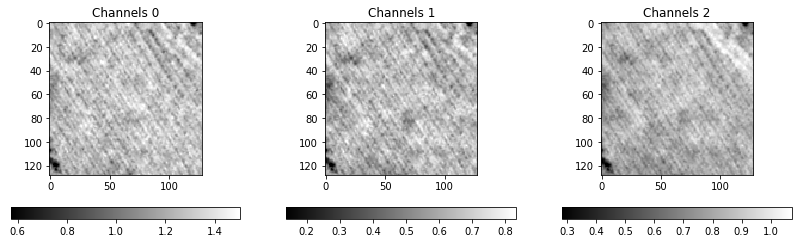

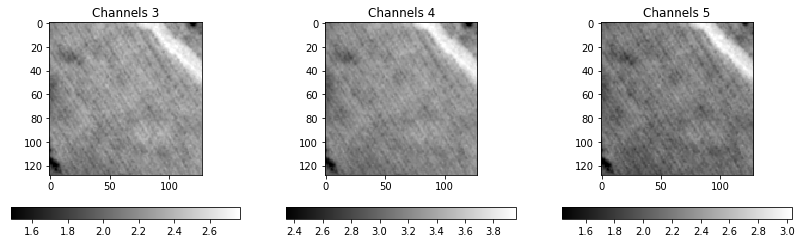

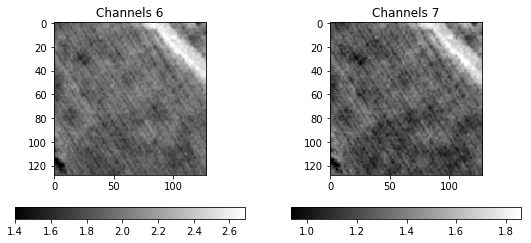

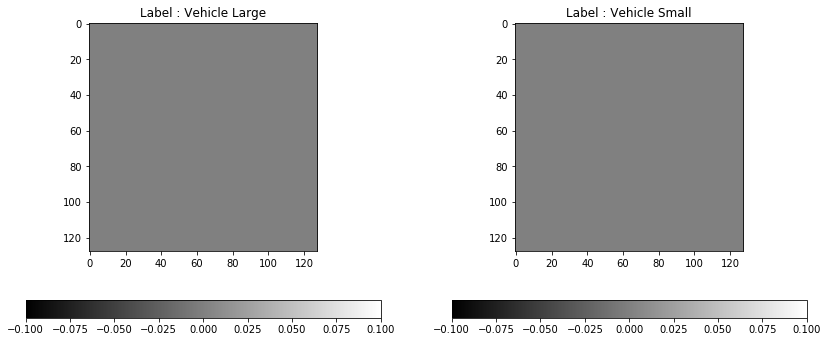

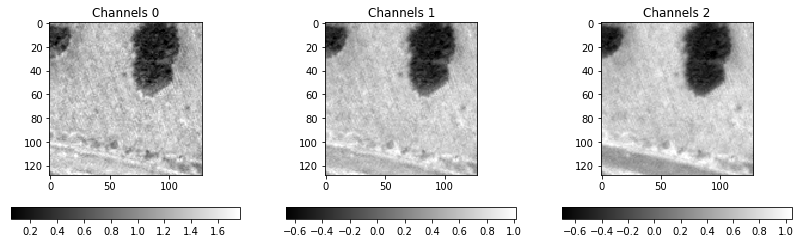

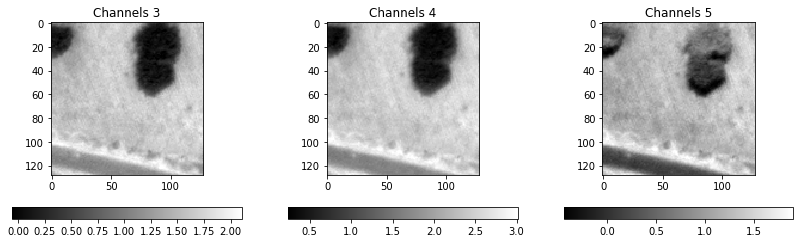

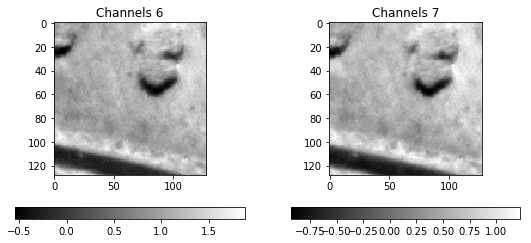

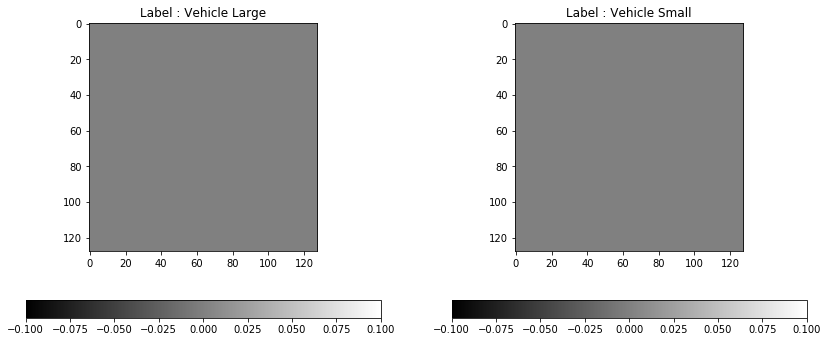

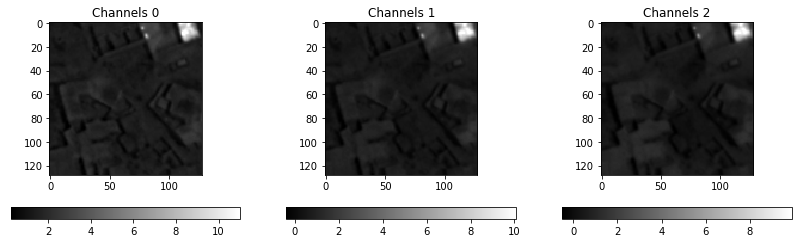

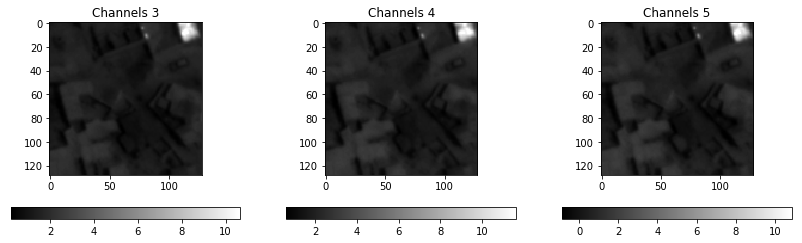

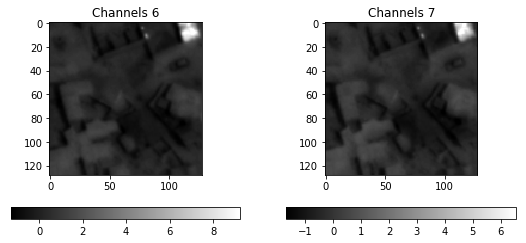

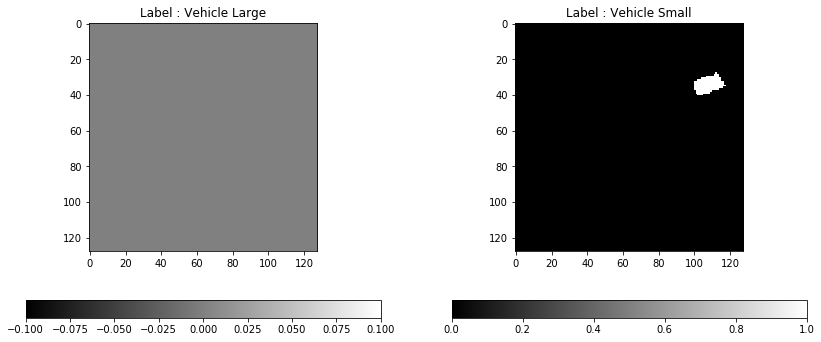

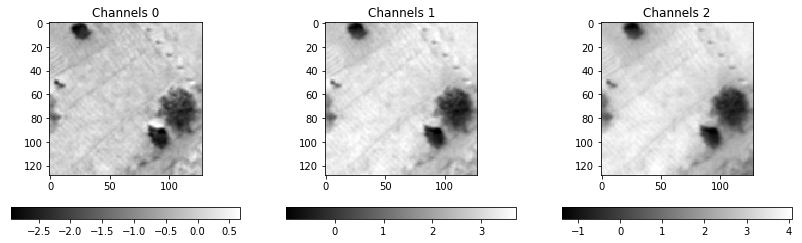

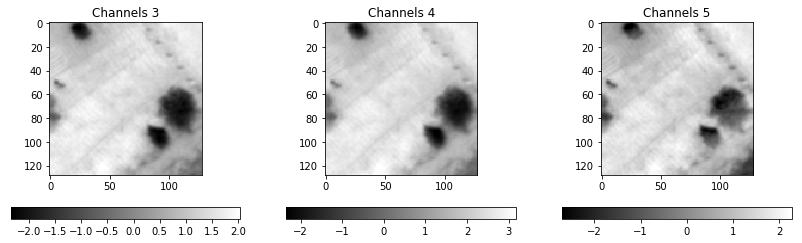

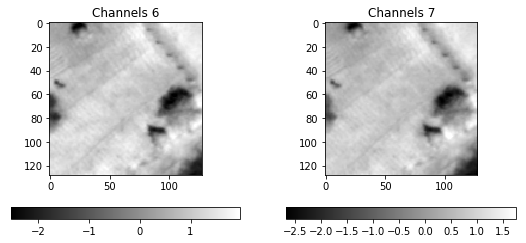

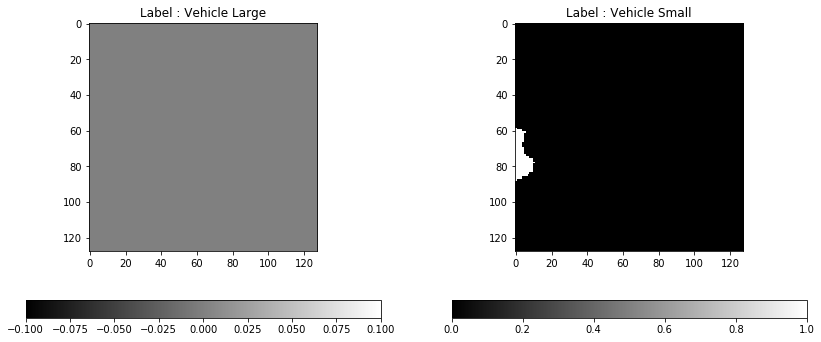

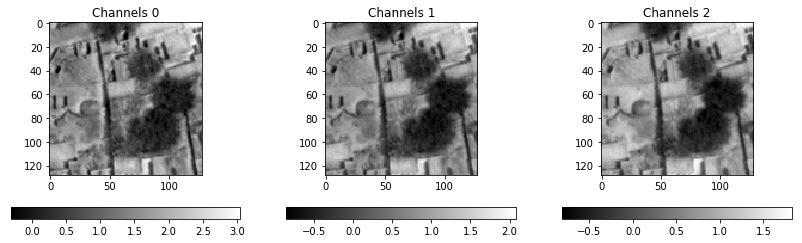

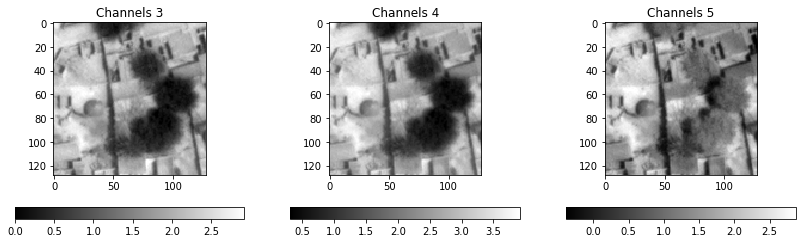

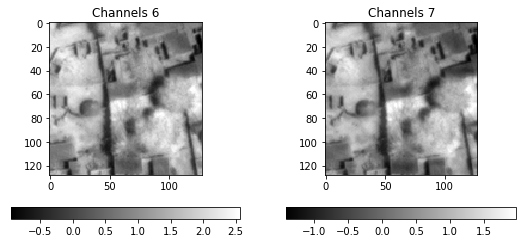

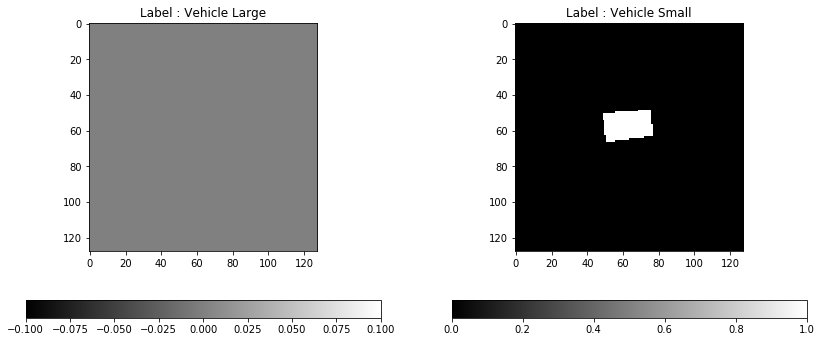

In [13]:
for X, Y in train_data_gen:
    print X.shape, Y.shape
    print X.min(), X.max(), Y.min(), Y.max()
    
    _n_labels = len(labels)
    _n_channels = min(15, len(channels))
    for i in range(batch_size):
        
        n, m = 3, int(_n_channels * 1.0 / 3.0 + 1.0)
        for j in range(_n_channels):
            if j % m == 0:
                plt.figure(figsize=(14, 4))                
            plt.subplot(1,m,j % m +1)
            display_img_1b(X[i,j,:,:])
            plt.title("Channels %i" % j)
                
        plt.figure(figsize=(14, 6))    
        if _n_labels < 8:
            n, m = 1, _n_labels
        else:
            n, m = 3, int(_n_labels * 1.0 / 3.0 + 1.0), 
        for j in range(_n_labels):
            plt.subplot(n, m,j+1)
            display_img_1b(Y[i,j,:,:])
            plt.title("Label : %s" % LABELS[labels[j]])

    break

In [15]:
class DataIterator:
    
    def __init__(self, image_ids
                    channels, # input data channels to select
                    classes, # output data classes to select
                    image_type='input',
                    label_type='label',
                    output_size=(256, 256),
                    balance_classes_method=2, # 0 = False, 1 = Method "last added", 2 = Method "equi-std", 3 = Method if only present
                    presence_percentage=2,
                    mean_image=None,
                    std_image=None,
                    random_rotation_angles=(0.0, 5.0, -5.0, 15.0, -15.0, 90.0, -90.0, 0.0),
                    random_scales=(),
                    resolution_levels=(1,),
                    n_images_same_time=5,
                    verbose=False):
        self.channels = channels
        gb = TRAIN_WKT[~TRAIN_WKT['MultipolygonWKT'].str.contains("EMPTY")].groupby('ClassType')    
        image_ids = get_image_ids(classes, gb)
        image_ids = list(set(image_ids) & set(image_ids_to_use))
        self.image_ids = image_ids
        self.image_type = image_type
        self.label_type = label_type
        self.output_size = output_size
        self.balance_classes_method = balance_classes_method
        self.presence_percentage = presence_percentage
        self.random_rotation_angles = random_rotation_angles
        self.random_scales = random_scales
        self.resolution_levels = resolution_levels
        self.n_images_same_time = n_images_same_time
        self.verbose = verbose
    
        self.mean_image = mean_image
        self.std_image = std_image
        if mean_image is not None and std_image is not None:
        if len(channels) < mean_image.shape[2]:
            self.mean_image = self.mean_image[:, :, channels]
            self.std_image = self.std_image[:, :, channels]
            
        
    __next__ = next
    
    def next(self):
        pass
    
    
        
    
    
    

In [9]:
from data_utils import get_resized_polygons
from collections import defaultdict

In [20]:
n_images_same_times = 5
classes = np.array([9, 10])
image_type = 'ms_pan'
output_size = (128, 128)

image_ids = train_ids[1:1+n_images_same_times]

In [21]:
def compute_all_polygons(image_ids):
    all_images_polygons = defaultdict(dict)
    for image_id in image_ids:
        img_shape = get_image_data(image_id, image_type, return_shape_only=True)
        one_image_polygons = get_resized_polygons(image_id, classes=classes, *img_shape[:2])
        all_images_polygons[image_id] = one_image_polygons
    return all_images_polygons

In [22]:
all_images_polygons = compute_all_polygons(image_ids)
all_images_polygons

defaultdict(dict,
            {'6100_1_3': {9: <shapely.geometry.multipolygon.MultiPolygon at 0x10dd70910>,
              10: <shapely.geometry.multipolygon.MultiPolygon at 0x1338dfd10>},
             '6110_3_1': {9: <shapely.geometry.multipolygon.MultiPolygon at 0x1338dff90>,
              10: <shapely.geometry.multipolygon.MultiPolygon at 0x12cb33790>},
             '6110_4_0': {9: <shapely.geometry.multipolygon.MultiPolygon at 0x1338dfe90>,
              10: <shapely.geometry.multipolygon.MultiPolygon at 0x1338df850>},
             '6120_2_2': {9: <shapely.geometry.multipolygon.MultiPolygon at 0x1338dfd50>,
              10: <shapely.geometry.multipolygon.MultiPolygon at 0x1339570d0>},
             '6140_3_1': {9: <shapely.geometry.multipolygon.MultiPolygon at 0x1338df9d0>,
              10: <shapely.geometry.multipolygon.MultiPolygon at 0x1338dfa10>}})

In [23]:
def compute_class_stats(all_images_polygons, classes):
    """
    Returns list of (count, area, mean_area) of each class.
    mean_area = area / count
    """
    stats = []
    for class_index in classes:
        count = 0
        area = 0.0
        for image_id in all_images_polygons: 
            one_image_polygons = all_images_polygons[image_id]
            count += len(one_image_polygons[class_index])
            area += one_image_polygons[class_index].area
        stats.append((count, area, area * 1.0 / count))
    return stats

In [24]:
stats = compute_class_stats(all_images_polygons, classes)

In [25]:
stats

[(33, 6196.146254635577, 187.76200771622962),
 (761, 30115.591431274952, 39.57370753124172)]

In [26]:
# def roi_iterator(image_ids, classes, balanced_classes=False):
#     all_images_polygons = compute_all_polygons(image_ids)
#     stats =  compute_class_stats(all_images_polygons, classes)
    
#     for 
    
#     pass

In [27]:


for image_id in image_ids:
    one_image_polygons = all_images_polygons[image_id]
    
    

In [46]:
image_id = image_ids[0]
img = get_image_data(image_id, image_type)
h, w, _ = img.shape

poly = all_images_polygons[image_id][classes[0]][0]
print poly.centroid, poly.area
# roi = [l,t,r,b]
l = max(int(np.round(poly.centroid.x - output_size[1]*0.5)), 0)
r = min(int(np.round(poly.centroid.x + output_size[1]*0.5)), w)

t = max(int(np.round(poly.centroid.y - output_size[0]*0.5)), 0)
b = min(int(np.round(poly.centroid.y + output_size[0]*0.5)), h)
roi = [l, t, r, b]
roi

POINT (550.5115306584981 3268.504747902028) 90.4542830913


[487, 3205, 615, 3333]

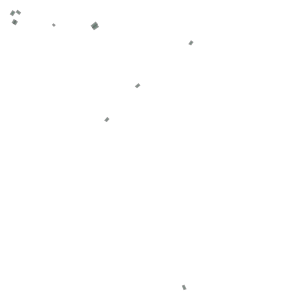

In [51]:
all_images_polygons[image_id][classes[0]]

In [48]:
label_img = get_image_data(image_id, 'label')

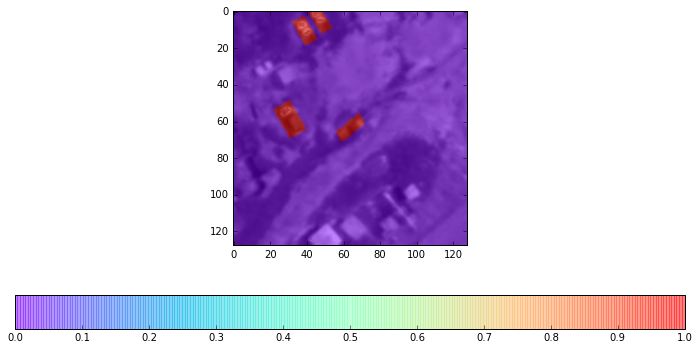

In [49]:
plt_st(12, 6)
display_img_1b(img[:,:,0], roi=roi, no_colorbar=True)
display_img_1b(label_img[:,:,classes[0]], alpha=0.5, roi=roi, cmap='rainbow', clim=[0,1])

In [46]:
rois = np.empty(len(classes), dtype=list)
for i, polygons in enumerate(selected_polygons):
    print "--", i
    for j, p in enumerate(polygons):
        print "---", j
        print p.exterior.centroid

-- 0
--- 0
POINT (1877.313690961554 3040.701381915067)
--- 1
POINT (824.4473806582447 2872.264377689565)
--- 2
POINT (2253.541010493439 244.3221470987476)
-- 1
--- 0
POINT (106.9164772033703 3324.967818298404)
--- 1
POINT (103.3361564761967 3291.788048412496)
--- 2
POINT (210.3834794363106 3260.968784174313)
--- 3
POINT (222.5561929453412 3253.328719441362)
--- 4
POINT (231.2584733682677 3244.442877940632)
--- 5
POINT (239.034979278949 3235.371914741428)
--- 6
POINT (249.7739636300027 3232.965332669622)
--- 7
POINT (487.7077020278226 3168.309841798933)
--- 8
POINT (330.4811650632221 3124.032575034456)
--- 9
POINT (819.4576474195391 3121.295257850072)
--- 10
POINT (320.8531101276585 3099.226267511504)
--- 11
POINT (788.0259795175876 3089.889970596082)
--- 12
POINT (757.8349756018606 3013.67801611422)
--- 13
POINT (319.5773619172775 2971.573495190147)
--- 14
POINT (317.0009557236439 2897.972643363288)
--- 15
POINT (1662.691025498802 2738.505277495253)
--- 16
POINT (400.3755834436098 2665

In [ ]:
roi = [2700, 2200, 2800, 2300]
# roi = None
h, w = img_pan.shape
for i in range(ll):
    plt_st(12,8)
    plt.subplot(121)
    display_img_1b(img_pan, roi)
    plt.subplot(122)
    plt.title("%s" % LABELS[labels[i]])
    display_img_1b(img_pan, roi, no_colorbar=True)
    display_img_1b(decision_func(Y_predictions[:h,:w,i], 0.2), roi, alpha=0.5, cmap='rainbow', clim=[0, 1])
    